In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Paths
train_dir = "dataset/train"
val_dir = "dataset/val"
test_dir = "dataset/test"

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 25

In [3]:
# Data Augmentation for Training Set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,         
    width_shift_range=0.1,       
    height_shift_range=0.1,      
    zoom_range=0.2,
    shear_range=0.15,            
    horizontal_flip=True,
    fill_mode='nearest'          
)

# No augmentation for validation and test, only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 5537 images belonging to 2 classes.
Found 1186 images belonging to 2 classes.
Found 1188 images belonging to 2 classes.


In [4]:
# Class Weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.594758064516129, 1: 0.7283609576427256}


In [5]:
# Load DenseNet121 without top layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

2025-04-24 12:09:44.197711: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-24 12:09:44.197746: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-24 12:09:44.197749: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-24 12:09:44.197773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-24 12:09:44.197788: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [6]:
# Callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("densenet_model1.keras", save_best_only=True, verbose=1)
]

# Train
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    callbacks=callbacks)

/opt/homebrew/Caskroom/miniforge/base/envs/cnn-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


2025-04-24 12:09:48.794971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.5359 - loss: 1.0444  
Epoch 1: val_loss improved from inf to 0.58389, saving model to densenet_model1.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 135s 743ms/step - accuracy: 0.5359 - loss: 1.0442 - val_accuracy: 0.6880 - val_loss: 0.5839
Epoch 2/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.5889 - loss: 0.9099  
Epoch 2: val_loss improved from 0.58389 to 0.53991, saving model to densenet_model1.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 139s 795ms/step - accuracy: 0.5890 - loss: 0.9099 - val_accuracy: 0.7386 - val_loss: 0.5399
Epoch 3/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.6238 - loss: 0.8320  
Epoch 3: val_loss improved from 0.53991 to 0.51504, saving model to densenet_model1.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 145s 833ms/step - accuracy: 0.6238 - loss: 0.8321 - val_accuracy: 0.7580 - val_loss: 0.5150
Epoch 4/25
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.6292 - loss: 0.8261  
Epoch 4: val_loss impr

In [8]:
# Fine-tune
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

train_generator.reset()
val_generator.reset()

fine_tune_epochs = 5
history_fine = model.fit(train_generator,
                         validation_data=val_generator,
                         epochs=fine_tune_epochs,
                         class_weight=class_weights,
                         callbacks=callbacks)

Epoch 1/5
  1/174 ━━━━━━━━━━━━━━━━━━━━ 5:11:30 108s/step - accuracy: 0.8750 - loss: 0.2550
Epoch 1: val_loss did not improve from 0.18887
174/174 ━━━━━━━━━━━━━━━━━━━━ 172s 372ms/step - accuracy: 0.8905 - loss: 0.2366 - val_accuracy: 0.9233 - val_loss: 0.1985
Epoch 2/5
 19/174 ━━━━━━━━━━━━━━━━━━━━ 35:48 14s/step - accuracy: 0.8431 - loss: 0.4418
Epoch 2: val_loss improved from 0.18887 to 0.18007, saving model to densenet_model1.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.8520 - loss: 0.4041 - val_accuracy: 0.9317 - val_loss: 0.1801
Epoch 3/5

Epoch 3: val_loss improved from 0.18007 to 0.17981, saving model to densenet_model1.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 48s 276ms/step - accuracy: 0.9375 - loss: 0.4443 - val_accuracy: 0.9317 - val_loss: 0.1798
Epoch 4/5
  9/174 ━━━━━━━━━━━━━━━━━━━━ 41:01 15s/step - accuracy: 0.8358 - loss: 0.3285
Epoch 4: val_loss improved from 0.17981 to 0.17683, saving model to densenet_model1.keras
174/174 ━━━━━━━━━━━━━━━━━━━━ 183s 929ms/step -

In [ ]:
# Evaluate on Test
test_generator.reset()
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int32")
y_true = test_generator.classes

# Accuracy
test_acc = np.mean(y_pred.flatten() == y_true)
print(f"Test Accuracy: {test_acc:.4f}")

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 73s 37ms/step
Test Accuracy: 0.9192



Classification Report:
              precision    recall  f1-score   support

      Benign       0.85      0.90      0.87       373
   Malignant       0.95      0.93      0.94       815

    accuracy                           0.92      1188
   macro avg       0.90      0.91      0.91      1188
weighted avg       0.92      0.92      0.92      1188

Confusion Matrix:
[[334  39]
 [ 57 758]]


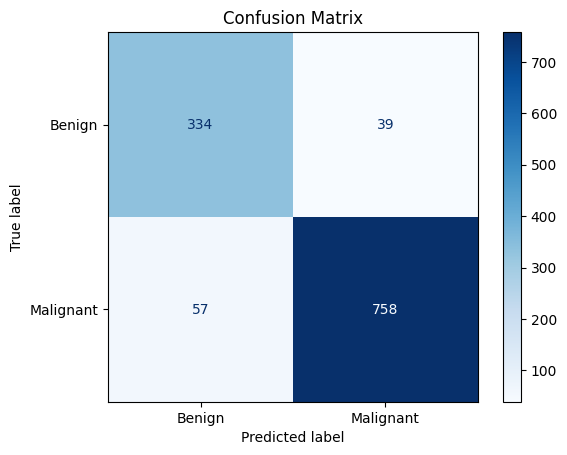

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

cm = confusion_matrix(y_true, y_pred)
# Confusion Matrix
print("Confusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

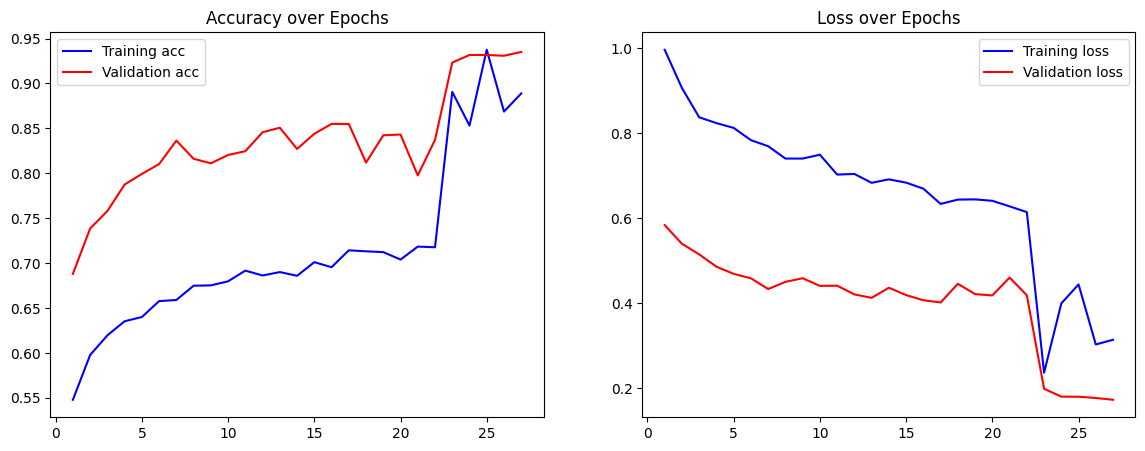

In [ ]:
# Plot training
def plot_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')
    plt.plot(epochs, val_acc, 'r-', label='Validation acc')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.show()

plot_history(history, history_fine)

In [ ]:
model.save("final_densenet_model1.keras")